In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets
from sklearn.linear_model import LogisticRegression

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
data = pd.read_csv('../../../data/GermanData.csv')

## Drop categorical features
data = data.drop(['1','2','4','5','8','10','11','12','14','15','16','17','18','19','20'],axis=1)


## Drop NULL values
data = data.dropna()

## for dowhy
## Change symbolics to numerics
data['sex'] = np.where(data['sex'] == 'A91', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A92', 0, data['sex'])
data['sex'] = np.where(data['sex'] == 'A93', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A94', 1, data['sex'])
data['sex'] = np.where(data['sex'] == 'A95', 0, data['sex'])

# mean = data.loc[:,"age"].mean()
# data['age'] = np.where(data['age'] >= mean, 1, 0)
data['age'] = np.where(data['age'] >= 25, 1, 0)
data['credit_history'] = np.where(data['credit_history'] == 'A30', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A31', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A32', 1, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A33', 2, data['credit_history'])
data['credit_history'] = np.where(data['credit_history'] == 'A34', 3, data['credit_history'])

data['savings'] = np.where(data['savings'] == 'A61', 1, data['savings'])
data['savings'] = np.where(data['savings'] == 'A62', 1, data['savings'])
data['savings'] = np.where(data['savings'] == 'A63', 2, data['savings'])
data['savings'] = np.where(data['savings'] == 'A64', 2, data['savings'])
data['savings'] = np.where(data['savings'] == 'A65', 3, data['savings'])

data['employment'] = np.where(data['employment'] == 'A72', 1, data['employment'])
data['employment'] = np.where(data['employment'] == 'A73', 1, data['employment'])
data['employment'] = np.where(data['employment'] == 'A74', 2, data['employment'])
data['employment'] = np.where(data['employment'] == 'A75', 2, data['employment'])
data['employment'] = np.where(data['employment'] == 'A71', 3, data['employment'])

data['Probability'] = np.where(data['Probability'] == 2, 0, 1)

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

print(data.head(5))
# This dataset size is very small. So repeating it to make it bigger
dataset_orig = pd.concat([dataset_orig]*5, ignore_index=True)

,sex,age,employment=Unemployed,credit_history=Delay,credit_history=None/Paid,credit_history=Other,savings=500+,savings=<500,savings=Unknown/None,employment=1-4 years,employment=4+ years,Probability
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Fairway

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
protected_attribute = 'sex'

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)
X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig_train.groupby(dataset_orig_train[protected_attribute] == 0)]
dataset_orig_male[protected_attribute] = 0
X_train_male, y_train_male = dataset_orig_male.loc[:, dataset_orig_male.columns != 'Probability'], dataset_orig_male['Probability']
clf_male = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_male.fit(X_train_male, y_train_male)
X_train_female, y_train_female = dataset_orig_female.loc[:, dataset_orig_female.columns != 'Probability'], dataset_orig_female['Probability']
clf_female = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_female.fit(X_train_female, y_train_female)

for index,row in dataset_orig_train.iterrows():
    row_ = [row.values[0:len(row.values)-1]]
    y_male = clf_male.predict(row_)
    y_female = clf_female.predict(row_)
    if y_male[0] != y_female[0]:        
        dataset_orig_train = dataset_orig_train.drop(index)

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))
print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

0.709
aod :sex -0.06
eod :sex 0.07
SPD: 0.11
DI: 0.11


# Graph

In [5]:
causal_graph = """
digraph {
credit_history;
savings;
employment;
age;
sex;
Probability;
U[label="Unobserved Confounders"];

sex -> Probability;
sex -> employment; age -> employment; employment -> Probability;
credit_history -> Probability;
age -> savings;
credit_history -> savings; 
savings -> Probability;
U->sex;U->Probability;
}
"""

## dowhy works for binary inputs only

dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

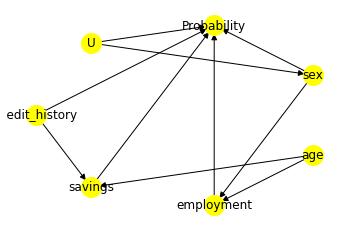

In [7]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
#         instruments=['employment','credit_history']
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [8]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                        
──────(Expectation(Probability|age,savings,credit_history))
d[sex]                                                     
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,age,savings,credit_history,U) = P(Probability|sex,age,savings,credit_history)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [9]:
causal_estimate = model.estimate_effect(identified_estimand,
#                                         method_name='iv.instrumental_variable'
                                      method_name="backdoor.propensity_score_stratification"
                                       )
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                        
──────(Expectation(Probability|age,savings,credit_history))
d[sex]                                                     
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,age,savings,credit_history,U) = P(Probability|sex,age,savings,credit_history)

## Realized estimand
b: Probability~sex+age+savings+credit_history
Target units: ate

## Estimate
Mean value: 0.035111114406813956

Causal Estimate is 0.035111114406813956


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [26]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.035111114406813956
New effect:0.029295937131710203



# Replace Treatment with Placebo

In [19]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.044760822587506556
New effect:0.0039099093325274436
p value:0.34



# Remove Random Subset of Data

In [20]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.044760822587506556
New effect:0.04428288725844259
p value:0.48

